In [1]:
import gc
import io
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
from scipy.sparse.linalg import eigsh
from torch.utils.hooks import RemovableHandle
from torchvision import transforms

In [2]:
def get_model(name: str):
    if "dino" in name:
        model = torch.hub.load("facebookresearch/dino:main", name)
        model.fc = torch.nn.Identity()
        val_transform = get_transform(name)
        patch_size = model.patch_embed.patch_size
        num_heads = model.blocks[0].attn.num_heads
    elif name in ["mocov3_vits16", "mocov3_vitb16"]:
        model = torch.hub.load("facebookresearch/dino:main", name.replace("mocov3", "dino"))
        checkpoint_file, size_char = {
            "mocov3_vits16": ("vit-s-300ep-timm-format.pth", "s"),
            "mocov3_vitb16": ("vit-b-300ep-timm-format.pth", "b"),
        }[name]
        url = f"https://dl.fbaipublicfiles.com/moco-v3/vit-{size_char}-300ep/vit-{size_char}-300ep.pth.tar"
        checkpoint = torch.hub.load_state_dict_from_url(url)
        model.load_state_dict(checkpoint["model"])
        model.fc = torch.nn.Identity()
        val_transform = get_transform(name)
        patch_size = model.patch_embed.patch_size
        num_heads = model.blocks[0].attn.num_heads
    else:
        raise ValueError(f"Unsupported model: {name}")
    model = model.eval()
    return model, val_transform, patch_size, num_heads


def get_transform(name: str):
    if any(
        x in name
        for x in (
            "dino",
            "mocov3",
            "convnext",
        )
    ):
        normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        transform = transforms.Compose(
            [
                transforms.Resize(size=512, interpolation=TF.InterpolationMode.BICUBIC),
                transforms.ToTensor(),
                normalize,
            ]
        )
    else:
        raise NotImplementedError()
    return transform


def get_diagonal(W: scipy.sparse.csr_matrix, threshold: float = 1e-12):
    D = W.dot(np.ones(W.shape[1], W.dtype))
    D[D < threshold] = 1.0  # Prevent division by zero.
    D = scipy.sparse.diags(D)
    return D

In [3]:
# Cache
torch.cuda.empty_cache()

# Parameters
model_name = "dino_vitb16"  # TODO: Figure out how to make this user-editable

# Load model
model, val_transform, patch_size, num_heads = get_model(model_name)

# Add hook
which_block = -1
if "dino" in model_name or "mocov3" in model_name:
    feat_out = {}

    def hook_fn_forward_qkv(module, input, output):
        feat_out["qkv"] = output

    handle: RemovableHandle = (
        model._modules["blocks"][which_block]
        ._modules["attn"]
        ._modules["qkv"]
        .register_forward_hook(hook_fn_forward_qkv)
    )
else:
    raise ValueError(model_name)


# GPU
if torch.cuda.is_available():
    print("CUDA is available, using GPU.")
    device = torch.device("cuda")
    model.to(device)
else:
    print("CUDA is not available, using CPU.")
    device = torch.device("cpu")

Using cache found in C:\Users\yitao/.cache\torch\hub\facebookresearch_dino_main


CUDA is available, using GPU.


In [4]:
@torch.no_grad()
def segment(inp: Image, numEig=5):
    # NOTE: The image is already resized to the desired size.

    # Preprocess image
    images: torch.Tensor = val_transform(inp)
    images = images.unsqueeze(0).to(device)

    # Reshape image
    P = patch_size
    B, C, H, W = images.shape
    H_patch, W_patch = H // P, W // P
    H_pad, W_pad = H_patch * P, W_patch * P
    T = H_patch * W_patch + 1  # number of tokens, add 1 for [CLS]

    # Crop image to be a multiple of the patch size
    images = images[:, :, :H_pad, :W_pad]

    # Extract features
    if "dino" in model_name or "mocov3" in model_name:
        model.get_intermediate_layers(images)[0].squeeze(0)
        output_qkv = feat_out["qkv"].reshape(B, T, 3, num_heads, -1 // num_heads).permute(2, 0, 3, 1, 4)
        feats = output_qkv[1].transpose(1, 2).reshape(B, T, -1)[:, 1:, :].squeeze(0)
    else:
        raise ValueError(model_name)

    # Normalize features
    normalize = True
    if normalize:
        feats = F.normalize(feats, p=2, dim=-1)

    # Compute affinity matrix
    W_feat = feats @ feats.T

    # Feature affinities
    threshold_at_zero = True
    if threshold_at_zero:
        W_feat = W_feat * (W_feat > 0)
    W_feat = W_feat / W_feat.max()  # NOTE: If features are normalized, this naturally does nothing
    W_feat = W_feat.cpu().numpy()

    # NOTE: Here is where we would add the color information. For simplicity, we will not add it here.
    # W_comb = W_feat + W_color * image_color_lambda  # combination
    # D_comb = np.array(get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check

    # Diagonal
    W_comb = W_feat
    D_comb = np.array(get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check

    # Compute eigenvectors
    try:
        eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=(numEig + 1), sigma=0, which="LM", M=D_comb)
    except:
        eigenvalues, eigenvectors = eigsh(D_comb - W_comb, k=(numEig + 1), which="SM", M=D_comb)
    eigenvalues = torch.from_numpy(eigenvalues)
    eigenvectors = torch.from_numpy(eigenvectors.T).float()

    # print(eigenvectors[0].shape)

    # Resolve sign ambiguity
    for k in range(eigenvectors.shape[0]):
        if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
            eigenvectors[k] = 0 - eigenvectors[k]

    # Arrange eigenvectors into grid
    # cmap = get_cmap('viridis')
    # output_images = []
    preds = []
    # eigenvectors_upscaled = []
    for i in range(1, numEig + 1):
        eigenvector = eigenvectors[i].reshape(1, 1, H_patch, W_patch)  # .reshape(1, 1, H_pad, W_pad)
        eigenvector: torch.Tensor = F.interpolate(
            eigenvector,
            size=(inp.size[1], inp.size[0]),
            mode="bicubic",
        )  # slightly off, but for visualizations this is okay
        # buffer = io.BytesIO()
        # plt.imsave(buffer, eigenvector.squeeze().numpy(), format="png")  # save to a temporary location
        # plt.imsave("./dataset/test/2/test.png", eigenvector.squeeze())
        # buffer.seek(0)
        # eigenvector_vis = Image.open(buffer).convert("L")
        # # eigenvector_vis = TF.to_tensor(eigenvector_vis).unsqueeze(0)
        # eigenvector_vis = np.array(eigenvector_vis)
        # # eigenvectors_upscaled.append(eigenvector)
        # output_images.append(eigenvector_vis)
        preds.append(eigenvector.squeeze())
    # output_images = torch.cat(output_images, dim=0)
    # output_images = make_grid(output_images, nrow=8, pad_value=1)

    # Also add CRF
    if False:
        # Imports
        import denseCRF

        # Parameters
        ParamsCRF = namedtuple("ParamsCRF", "w1 alpha beta w2 gamma it")
        DEFAULT_CRF_PARAMS = ParamsCRF(
            w1=6,  # weight of bilateral term  # 10.0,
            alpha=40,  # spatial std  # 80,
            beta=13,  # rgb  std  # 13,
            w2=3,  # weight of spatial term  # 3.0,
            gamma=3,  # spatial std  # 3,
            it=5.0,  # iteration  # 5.0,
        )

        # Get unary potentials
        unary_potentials = eigenvectors_upscaled[0].squeeze(1).squeeze(0)
        unary_potentials = (unary_potentials - unary_potentials.min()) / (
            unary_potentials.max() - unary_potentials.min()
        )
        unary_potentials_np = torch.stack((1 - unary_potentials, unary_potentials), dim=-1).cpu().numpy()
        img_np = images.cpu().numpy().transpose(0, 2, 3, 1)
        img_np = (img_np * 255).astype(np.uint8)[0]

        # Return result of CRF
        out = denseCRF.densecrf(img_np, unary_potentials_np, DEFAULT_CRF_PARAMS)
        out = out * 255
        output_images.append(out)

    # # Postprocess for Gradio
    # output_images = np.array(TF.to_pil_image(output_images))
    # print(f"{len(output_images)=}")

    # Garbage collection and other memory-related things
    gc.collect()
    # del eigenvector, eigenvector_vis, eigenvectors, W_comb, D_comb
    del eigenvector, eigenvectors, W_comb, D_comb

    # return output_images
    return preds

In [1]:
from myutils.DSS import segment
from myutils.img_loader import get_imgNames, get_img_by_id
from myutils.processors import savePic, toGreyscale

Using cache found in C:\Users\yitao/.cache\torch\hub\facebookresearch_dino_main


CUDA is available, using GPU.


In [16]:
test_img = get_img_by_id(173)
preds = segment(test_img)
print(preds[0].max(), preds[1].max(), preds[2].max(), preds[3].max(), preds[4].max())
print(preds[0].min(), preds[1].min(), preds[2].min(), preds[3].min(), preds[4].min())

tensor(0.0171) tensor(0.0083) tensor(0.0325) tensor(0.0568) tensor(0.0435)
tensor(-0.0028) tensor(-0.0014) tensor(-0.0285) tensor(-0.0221) tensor(-0.0333)


In [5]:
import os
from myutils.img_loader import get_imgNames, get_img_by_id
from myutils.processors import savePic, toGreyscale

img_names = get_imgNames()

In [6]:
test_img = get_img_by_id(200)
preds = segment(test_img)
pred = preds[1]
gs = toGreyscale(pred)

In [9]:
# save tensors
for i in range(len(img_names)):
    input_image = get_img_by_id(i + 1)
    preds = segment(input_image)
    for j in range(len(preds)): 
        path = "./dataset/preds/dss/" + str(j) + "/"
        output_dir = os.path.exists(path)
        if not output_dir:
            os.makedirs(path)
        torch.save(preds[j], path + img_names[i] + ".pt")
    print("Progress: \t" + str((i + 1)) + "/" + str(len(img_names)), end="\r")
print("FINISHED!")

FINISHED! 	726/726


In [10]:
for i in range(len(img_names)):
    input_image = get_img_by_id(i + 1)
    preds = segment(input_image)
    for j in range(len(preds)):
        path = "./dataset/greyscales/dss/" + str(j) + "/"
        output_dir = os.path.exists(path)
        if not output_dir:
            os.makedirs(path)
        gs = toGreyscale(preds[j])
        savePic(gs.numpy(), path, img_names[i] + ".png", True)
    print("Progress: \t" + str((i + 1)) + "/" + str(len(img_names)), end="\r")
print("FINISHED!")

FINISHED! 	726/726


<class 'torch.Tensor'>
<class 'numpy.ndarray'>


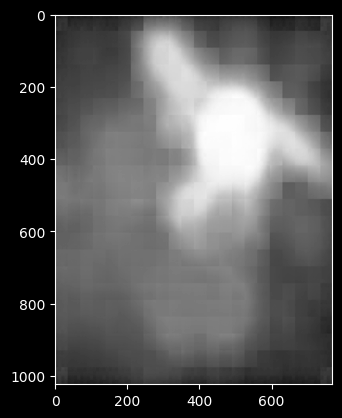

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from myutils.img_loader import get_imgNames, get_img_by_id
from myutils.getPred import seg_clipseg
from myutils.processors import savePic, toGreyscale

test_preds = seg_clipseg(get_img_by_id(170))

test_pred = test_preds[2]
# plt.show(test_pred)
test_pred_gs = toGreyscale(test_pred)
print(type(test_pred_gs))
test_pred_gs = test_pred_gs.numpy()
print(type(test_pred_gs))
img = Image.fromarray(test_pred_gs.astype(np.uint8), mode = "L")
plt.imshow(img, cmap='gray')

In [7]:
def toGreyscale(pred, method=1):
    # Convert ndarray to tensor
    if type(pred) is np.ndarray:
        pred = torch.from_numpy(pred)

    min = pred.min()
    max = pred.max()

    # use min max values to map predictions to (0, 255)
    if method == 1:
        ratio = (pred - min).true_divide(max - min)
    elif method == 2:
        ratio = torch.sigmoid(pred)
    else:
        print("wrong mode.")
        return pred

    return (ratio * 255).int()


def toBinary(pred, t: float, normMethod: int = 1):
    """Convert predictions to binary format

    Params:
        pred: prediction out from model.
        t: thredshold, float, from 0 to 1.
        _norm: int, should normalize, 0|1|2|
            0: no normalization
            1: default, minmax normalization
            2: sigmoid

    Return:
        Tensor consists of 0 and 1.
    """

    pred = toGreyscale(pred, normMethod)
    # Global threshold
    if t <= 1 and t >= 0:
        pred = pred.true_divide(255)
        one = torch.ones_like(pred)
        zero = torch.zeros_like(pred)
        pred_bi = torch.where(pred < t, zero, one)

    # mean adaptive
    elif t == 2.0:
        pred_bi = pred

    else:
        print("wrong threshold value.")
        pred_bi = pred

    return pred_bi

In [16]:
pred_gs_1 = toGreyscale(test_preds[0]).long()
pred_gs_1

tensor([[ 9,  9, 10,  ..., 23, 21, 20],
        [ 9, 10, 11,  ..., 23, 22, 21],
        [10, 11, 13,  ..., 23, 22, 22],
        ...,
        [31, 31, 30,  ..., 29, 27, 26],
        [29, 29, 28,  ..., 28, 26, 24],
        [29, 28, 27,  ..., 28, 25, 24]])

In [4]:
Image.fromarray(pred_gs_1.numpy(), mode='L').save("./dataset/test/gs1.png")

NameError: name 'pred_gs_1' is not defined

In [9]:
pred_gs_2 = toGreyscale(test_preds[0], 2)
pred_gs_2

tensor([[ 2,  2,  2,  ...,  9,  9,  9],
        [ 2,  2,  2,  ...,  9,  9,  9],
        [ 2,  2,  2,  ..., 10, 10, 10],
        ...,
        [ 6,  6,  6,  ..., 15, 14, 14],
        [ 5,  5,  5,  ..., 13, 13, 12],
        [ 5,  5,  5,  ..., 12, 12, 11]])

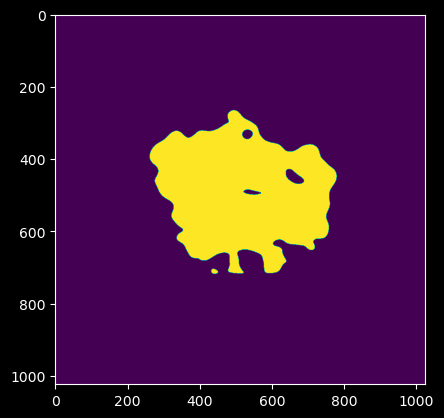

In [10]:
plt.imshow(pred_gs_2)

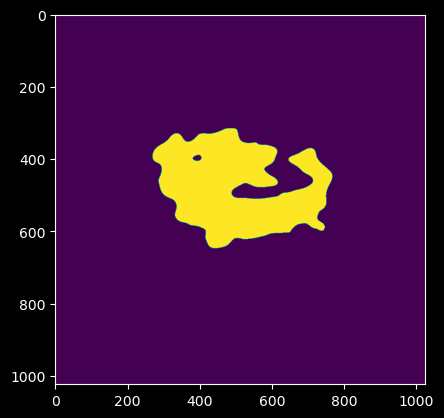

In [11]:
plt.imshow(toBinary(pred[0], 0.68, 1))

In [3]:
import cv2 as cv

pred_gs_1 = pred[0].numpy().astype(np.uint8)

ret, thresh1 = cv.threshold(pred_gs_1, 127, 255, cv.THRESH_BINARY)
ret, thresh2 = cv.threshold(pred_gs_1, 127, 255, cv.THRESH_BINARY_INV)
ret, thresh3 = cv.threshold(pred_gs_1, 127, 255, cv.THRESH_TRUNC)
ret, thresh4 = cv.threshold(pred_gs_1, 127, 255, cv.THRESH_TOZERO)
ret, thresh5 = cv.threshold(pred_gs_1, 127, 255, cv.THRESH_TOZERO_INV)
titles = ["Original Image", "BINARY", "BINARY_INV", "TRUNC", "TOZERO", "TOZERO_INV"]
images = [pred_gs_1, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2, 3, i + 1), plt.imshow(images[i], "gray", vmin=0, vmax=255)
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
plt.show()

NameError: name 'pred' is not defined

In [12]:
from myutils.img_loader import get_img_by_id, get_imgNames
from myutils.processors import toBinary

In [10]:
special_case_ids = [324, 104]

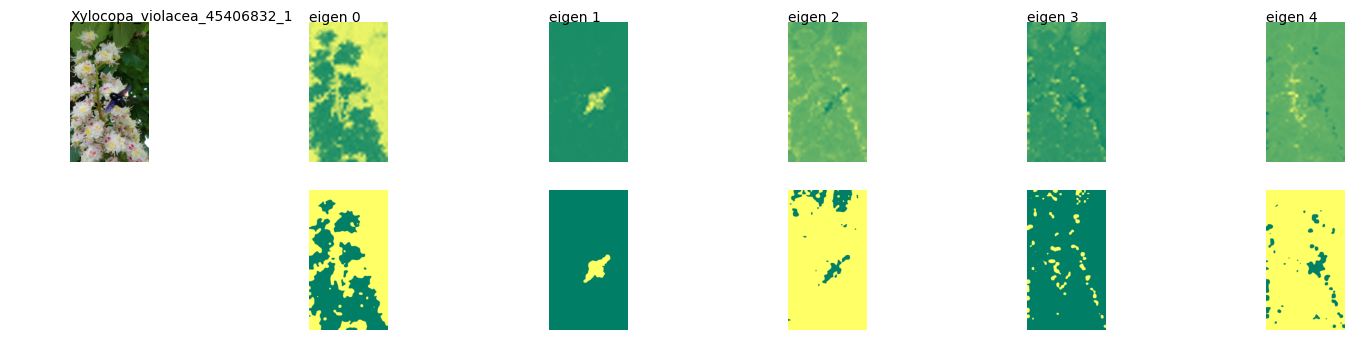

In [14]:
chosen_id = 324
input_image = get_img_by_id(chosen_id)
preds = segment(input_image)
img_names = get_imgNames()

# for i in range(len(preds)):
#     preds[i] = toBinary(preds[i], 0.5)

_, ax = plt.subplots(2, len(preds) + 1, figsize=(3 * (len(preds) + 1), 4))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_image)
ax[0][0].text(0, -15, img_names[chosen_id - 1])
[ax[0][i + 1].text(0, -10, "eigen " + str(i)) for i in range(len(preds))]
[ax[0][i + 1].imshow(preds[i], cmap="summer") for i in range(len(preds))]
[ax[1][i + 1].imshow(toBinary(preds[i], 0.33), cmap="summer") for i in range(len(preds))]